# Network analysis with Wikipedia

[Brian C. Keegan](https://www.brianckeegan.com)  
Department of Information Science, University of Colorado Boulder  
MIT License

## Learning objectives

* The affordances of the MediaWiki software powering Wikipedia
* How different interactions with Wikipedia generate different relational data
* Retrieving data from Wikipedia's API using the `wikifunctions` wrapper
* Converting relational data into networks using `networkx`
* Understanding the differences between directed, undirected, and bipartite networks

## Loading libraries

Some of the basic data analysis libraries.

In [1]:
# Basic data libraries
import numpy as np
import pandas as pd
import json

from datetime import datetime, timezone

# Data visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Network analysis library
import networkx as nx

We are also going to use [`wikifunctions`](https://github.com/brianckeegan/wikifunctions/), a lightweight wrapper for retreiving data from the [MediaWiki API](https://www.mediawiki.org/wiki/API:Main_page) that powers projects like Wikipedia. This is just a plain Python script file, there's nothing to `pip` or `conda` install: just download "wikifunction.py" and put it in the same directory as your notebook.

In [2]:
import wikifunctions as wf

We will also need to use Gephi to visualize the networks.

## Basics of Wikipedia

Wikipedia is the "free encyclopedia that anyone can edit" and [was created in January 2021](https://en.wikipedia.org/wiki/History_of_Wikipedia).

Most of us experience Wikipedia by going to an article, like [Elizabeth II](https://en.wikipedia.org/wiki/Elizabeth_II). But there is a lot of data and interactions that go on behind the scenes for which we can access interesting data. Wikipedia articles have corresponding pages for discussions, policies, templates, and images. There are also Wikipedias available in other languages and links connecting articles across languages.

* **Revision histories** Wikipedia preserves the content and metadata about every<sup>*</sup> revision to an article going back to late 2001. Revision history data before then was mostly lost during a server migration. 
   * `get_all_page_revisions`, `get_page_revisions_from_date`
* **Article content** The current and previous content of articles can be retrieved from the API.
  * Current article content
    * `get_page_content`, `get_page_raw_content`, `get_page_outlinks`, `get_page_externallinks`
  * Previous revision content
    * `get_revision_content`, `get_revision_raw_content`, `get_revision_outlinks`, `get_revision_externallinks`
* **Interlanguage links** The versions of other Wikipedia articles about a topic can be accessed via inter-language links.
  * `get_interlanguage_links`
* **Pageviews** The number of times a Wikipedia page is accessed by a user, bot, and/or spider is available since July 2015.
  * `get_pageviews`
* **Categories** Wikipedia articles are organized into a hierarcy of categories by topic.
  * `get_category_memberships`, `get_category_subcategories`, `get_category_members`
* **Users** Metadata and the contribution histories of users
  * `get_user_info`, `get_user_contributions`

## Retrieving data from Wikipedia

In [3]:
title = 'Elizabeth II'

### Content

`get_page_content` returns a (relatively) clean string that is the content from the body of the article.

In [4]:
current_content = wf.get_page_content(title)
print(current_content[:1000])



Elizabeth II (Elizabeth Alexandra Mary; 21 April 1926 – 8 September 2022) was Queen of the United Kingdom and other Commonwealth realms from 6 February 1952 until her death in 2022. She was queen regnant of 32 sovereign states during her lifetime and was head of state of 15 realms at the time of her death. Her reign of 70 years and 214 days was the longest of any British monarch and the longest verified reign of any female head of state in history.

Elizabeth was born in Mayfair, London, as the first child of the Duke and Duchess of York (later King George VI and Queen Elizabeth The Queen Mother). Her father acceded to the throne in 1936 upon the abdication of his brother Edward VIII, making the ten-year-old Princess Elizabeth the heir presumptive. She was educated privately at home and began to undertake public duties during the Second World War, serving in the Auxiliary Territorial Service. In November 1947, she married Philip Mountbatten, a former prince of Greece and Denmark, and

If you want to parse the raw HTML content of the entire article, use `get_page_raw_content`.

In [16]:
raw_current_content = wf.get_page_raw_content(title)
raw_current_content[20000:21000]

'ghter-in-law <a href="/wiki/Diana,_Princess_of_Wales" title="Diana, Princess of Wales">Diana</a>—support for the monarchy in the United Kingdom remained consistently high throughout her lifetime, as did her personal popularity. Elizabeth died aged 96 at <a href="/wiki/Balmoral_Castle" title="Balmoral Castle">Balmoral Castle</a>, Aberdeenshire, in September 2022 and was succeeded by her eldest son, Charles&#160;III.\n</p>\n\n<h2><span class="mw-headline" id="Early_life">Early life</span></h2>\n<style data-mw-deduplicate="TemplateStyles:r1096954695/mw-parser-output/.tmulti">.mw-parser-output .tmulti .multiimageinner{display:flex;flex-direction:column}.mw-parser-output .tmulti .trow{display:flex;flex-direction:row;clear:left;flex-wrap:wrap;width:100%;box-sizing:border-box}.mw-parser-output .tmulti .tsingle{margin:1px;float:left}.mw-parser-output .tmulti .theader{clear:both;font-weight:bold;text-align:center;align-self:center;background-color:transparent;width:100%}.mw-parser-output .tmul

Get the content of the revision in the past with `get_revision_content`. Revision [562359](https://en.wikipedia.org/w/index.php?title=Elizabeth_II&oldid=562359) corresponds to an edit from December 15, 2002.

In [17]:
previous_content = wf.get_revision_content(562359)
print(previous_content[:1000])

Elizabeth Alexandra Mary Windsor or Elizabeth II (born April 21, 1926) is the Queen and head of state of the United Kingdom (and several other Commonwealth countries) since February 6, 1952. Her coronation took place in Westminster Abbey on June 2, 1953.



Born in London, England, by Caesarean section she is the elder daughter of George VI (then Duke of York) and Elizabeth Bowes-Lyon, her younger sister being the late Princess Margaret. Elizabeth succeeded to the throne following the death of her father in 1952.

She married Prince Philip of Greece and Denmark in November 1947. They have four children.

Despite a succession of controversies about the rest of the royal family, particularly throughout the 1980s and 1990s (including wide reportage of Prince Philip's propensity for verbal gaffes, and the marital difficulties of her children), Queen Elizabeth remains a remarkably uncontroversial and widely respected figure. She has managed to reflect the expectations of the British publ


You can get the raw markup for this revision with `get_revision_raw_content`.

In [19]:
raw_previous_content = wf.get_revision_raw_content(562359)
raw_previous_content[1000:2000]

'ad?wpDestFile=Elizabeth_ii.jpg" class="new" title="File:Elizabeth ii.jpg">File:Elizabeth ii.jpg</a>\r\n</td>\r\n</tr>\r\n</tbody></table>\r\n<p>Born in <a href="/wiki/London" title="London">London</a>, <a href="/wiki/England" title="England">England</a>, by <a href="/wiki/Caesarean_section" title="Caesarean section">Caesarean section</a> she is the elder daughter of <a href="/wiki/George_VI_of_the_United_Kingdom" class="mw-redirect" title="George VI of the United Kingdom">George VI</a> (then Duke of York) and <a href="/wiki/Queen_Mother" class="mw-redirect" title="Queen Mother">Elizabeth Bowes-Lyon</a>, her younger sister being the late <a href="/wiki/Princess_Margaret" class="mw-redirect" title="Princess Margaret">Princess Margaret</a>. Elizabeth succeeded to the throne following the death of her father in <a href="/wiki/1952" title="1952">1952</a>.\r\n</p><p>She married <a href="/wiki/Prince_Philip" class="mw-redirect" title="Prince Philip">Prince Philip of Greece and Denmark</a> in

To get only the hyperlinks present in the body of an article.

In [24]:
current_hyperlinks = wf.get_page_outlinks(title)
current_hyperlinks[:10]

['Queen of the United Kingdom',
 'Commonwealth realm',
 'Death and state funeral of Elizabeth II',
 'Queen regnant',
 'List of sovereign states headed by Elizabeth II',
 'Head of state',
 'List of monarchs in Britain by length of reign',
 'List of longest-reigning monarchs',
 'Mayfair',
 'King George VI']

In [26]:
previous_hyperlinks = wf.get_revision_outlinks(562359)
previous_hyperlinks[:10]

['April 21',
 '1926',
 'Queen (monarch)',
 'Head of state',
 'United Kingdom',
 'The Commonwealth',
 'February 6',
 '1952',
 'Westminster Abbey',
 'June 2']

To get the external links (generally citations) in the body of an article.

In [27]:
current_externallinks = wf.get_page_externallinks(title)
current_externallinks[:10]

['https://www.thegazette.co.uk/London/issue/33153/page/1',
 'https://www.royal.uk/her-majesty-the-queen?ch=5',
 'https://web.archive.org/web/20160507231247/https://www.royal.uk/her-majesty-the-queen?ch=5',
 'https://www.royal.uk/queen-elizabeth-queen-mother',
 'https://web.archive.org/web/20160507183311/https://www.royal.uk/queen-elizabeth-queen-mother',
 'https://www.bbc.co.uk/archive/childrens-hour--princess-elizabeth/z7wm92p',
 'https://web.archive.org/web/20191127053143/https://www.bbc.co.uk/archive/childrens-hour--princess-elizabeth/z7wm92p',
 'https://web.archive.org/web/20100328170101/http://www.royal.gov.uk/HMTheQueen/Publiclife/EarlyPublicLife/Earlypubliclife.aspx',
 'http://www.royal.gov.uk/HMTheQueen/Publiclife/EarlyPublicLife/Earlypubliclife.aspx',
 'https://www.thegazette.co.uk/London/issue/36973/supplement/1315']

In [28]:
previous_externallinks = wf.get_revision_externallinks(562359)
previous_externallinks[:10]

['http://www.royal.gov.uk/output/Page412.asp']

There are several kinds of relationships here:
* **article-to-article** Hyperlinks of articles linking to other articles
* **article-to-website** Links of articles to other websites

### Revision histories

The history of all the changes made to an article can be retrieved as a DataFrame. Most articles have a dozens to hundreds of revisions, but some articles (particularly about prominent people) may have tens of thousands of revisions that requires a few seconds to retrieve.

Each row of data is meta-data about a specific revision to the article:
* **revid** The revision ID
* **parentid** The previous revision ID that was modified by this revision
* **user** The username of the editor, this includes IP addresses of unregistered editors
* **anon** Whether the editor was a registered editor (NaN) or an unregistered editor (True)
* **userid** A numeric indicator of the user account. User is more helpful since unregistered editors are all 0 userids.
* **timestamp** The timestamp at UTC-0 of when the revision was made
* **size** The length of the article's content in bytes
* **sha1** A hash of the revision's content that is helpful for comparing whether two revisions are identical
* **comment** An optional comment left by the editor explaining what they're changing and why
* **Xhidden** Rarely-used fields if the article content or comment is suppressed, generally for severe policy violations
* **page** Name of the article
* **date** YYYY-MM-DD formatted date of the revision
* **diff** Change in the size of the article from the previous revision
* **lag** Time elapsed (in seconds) since the previous revision
* **age** Time elapsed (in days) since the creation of the article

There are several relationships present within this data:
* **editor-to-article** What editors contributed to what articles?
* **revid-to-revid** What revisions modified what previous revisions?
* **sha1-to-sha1** What revisions are identical to what other revisions?

In [20]:
revision_history = wf.get_all_page_revisions(title)
revision_history.head()

,revid,parentid,user,anon,userid,timestamp,size,sha1,comment,sha1hidden,commenthidden,page,date,diff,lag,age
0,249061,0,61.9.128.xxx,True,0,2001-11-16 03:24:33+00:00,780,cc5c02a29b5990567cd26323ddd2d3886d14a8fc,mention she's also head of state of several ot...,NaN,NaN,Elizabeth II,2001-11-16,NaN,NaN,0.000000
1,249062,249061,Berek,NaN,79,2001-12-14 19:38:09+00:00,840,4d3c00474e85d92a90a4b5509230515c7b4ef84d,Mentioned QE2's coronation - anyone know the e...,NaN,NaN,Elizabeth II,2001-12-14,60.0,2477616.0,28.676111
2,249063,249062,Paul Drye,NaN,6,2001-12-14 23:06:32+00:00,856,00775574260757f567eabbcb282f5cf9abb868e7,"June 2nd, 1953",NaN,NaN,Elizabeth II,2001-12-14,16.0,12503.0,28.820822
3,19902,249063,Conversion script,NaN,1226483,2002-02-25 15:51:15+00:00,935,9e42502da98959d456a0cc6c65c61d76bfda9042,Automated conversion,NaN,NaN,Elizabeth II,2002-02-25,79.0,6281083.0,101.518542
4,19962,19902,62.253.64.7,True,0,2002-02-28 02:55:35+00:00,943,a90261cb092d27801923f3777d481d71b4299511,*,NaN,NaN,Elizabeth II,2002-02-28,8.0,212660.0,103.979884


Let's make a simple visualization of the number of monthly revisions over time.

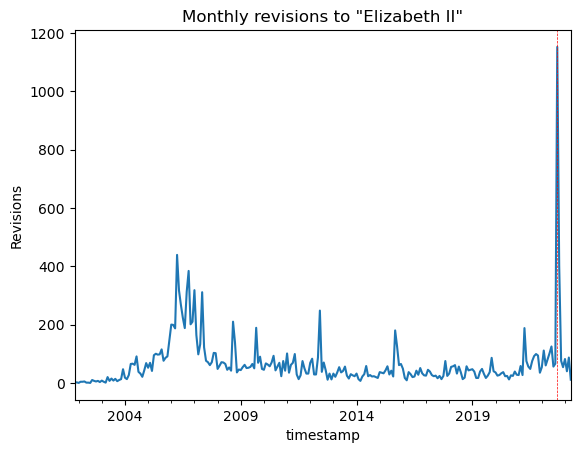

In [121]:
monthly_revisions = revision_history.groupby(pd.Grouper(key='timestamp',freq='1M')).agg({'revid':'nunique'})['revid']

ax = monthly_revisions.plot()
ax.set_ylabel('Revisions')
ax.set_title('Monthly revisions to "Elizabeth II"')
ax.axvline(pd.Timestamp('2022-09-08'),lw=.5,c='r',ls='--')

Or the changing length of the article based on the average article size in each month.

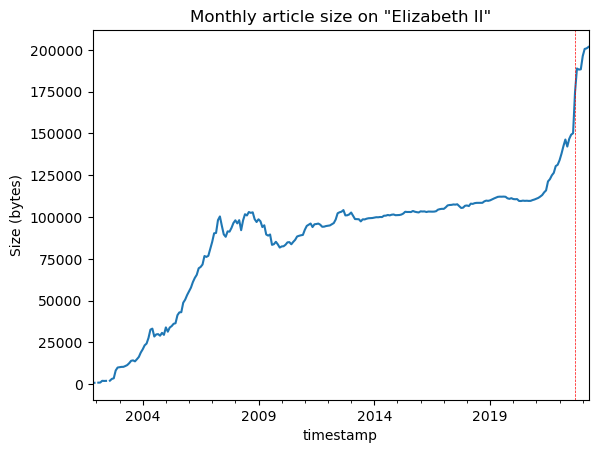

In [120]:
monthly_revisions = revision_history.groupby(pd.Grouper(key='timestamp',freq='1M')).agg({'size':'mean'})['size']

ax = monthly_revisions.plot()
ax.set_ylabel('Size (bytes)')
ax.set_title('Monthly article size on "Elizabeth II"')
ax.axvline(pd.Timestamp('2022-09-08'),lw=.5,c='r',ls='--')

### Categories

Get the categories of which an article is a member.

In [21]:
category_members = wf.get_category_memberships(title)
category_members

['Category:1926 births',
 'Category:2022 deaths',
 'Category:20th-century British monarchs',
 'Category:20th-century British women',
 'Category:21st-century British monarchs',
 'Category:21st-century British women',
 'Category:Auxiliary Territorial Service officers',
 'Category:British Anglicans',
 'Category:British Presbyterians',
 'Category:British philanthropists',
 'Category:British princesses',
 'Category:British racehorse owners and breeders',
 'Category:British women in World War II',
 "Category:Burials at St George's Chapel, Windsor Castle",
 'Category:Daughters of emperors',
 'Category:Daughters of kings',
 'Category:Deaths in Scotland',
 'Category:Dethroned monarchs',
 'Category:Duchesses of Edinburgh',
 'Category:Elizabeth II',
 'Category:Heads of state of Antigua and Barbuda',
 'Category:Heads of state of Australia',
 'Category:Heads of state of Barbados',
 'Category:Heads of state of Belize',
 'Category:Heads of state of Canada',
 'Category:Heads of state of Fiji',
 'Categ

Get the members of a category. These can be recrusively fetched to an arbitrary depth (which could take a really long time!) by changing the depth parameter from 0 (only members of current category), to 1 (current categories and members of subcategories), *etc*.

In [23]:
wf.get_category_members('Category:Heirs to the British throne',depth=0)

['List of heirs to the British throne',
 'Charles III',
 'Edward VIII',
 'Prince Edward, Duke of York and Albany',
 'Elizabeth II',
 'Ernest Augustus, King of Hanover',
 'Frederick, Prince of Wales',
 'Prince Frederick, Duke of York and Albany',
 'George I of Great Britain',
 'George II of Great Britain',
 'George III',
 'George IV',
 'George V',
 'George VI',
 'Sophia of Hanover',
 'Victoria, Princess Royal',
 'William, Prince of Wales']

There are several kinds of relationships here:
* **article-to-category** What categories is an article a member of?
* **category-to-article** What articles are included in a category?

### Pageviews

Get the pageviews since July 2015 about an article.

In [29]:
pageviews = wf.get_pageviews(title)
pageviews.head()

timestamp
2015-07-01    17717
2015-07-02    16529
2015-07-03    16534
2015-07-04    17353
2015-07-05    26460
Name: views, dtype: int64

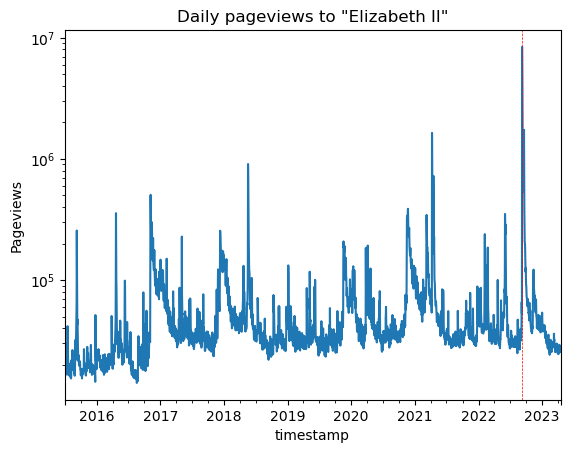

In [125]:
ax = pageviews.plot()
ax.set_yscale('log')
ax.set_ylabel('Pageviews')
ax.set_title('Daily pageviews to "Elizabeth II"')
ax.axvline(pd.Timestamp('2022-09-08'),lw=.5,c='r',ls='--')

The pageview data can be correlated with other articles' pageview data to make article-to-article correlated consumption relations. For all the articles "Elizabeth II" links to, get their pageviews.

In [127]:
# Empty container to store data
pageviews_d = {}

# Get the pageviews for Elizabeth II
pageviews_d[title] = wf.get_pageviews(title)

# For each article among her unique neighbors
for _article in set(current_hyperlinks):
    
    # Try to get their pageviews
    try:
        pageviews_d[_article] = wf.get_pageviews(_article)
        
    # Break the loop if I interrupt
    except KeyboardInterrupt:
        break
    
    # Print out articles with errors and continue to the next
    except:
        print(_article)
        pass

Convert the `pageviews_d` dictionary of article pageview Series into a DataFrame and save this valuable data to disk.

In [128]:
pageviews_df = pd.DataFrame(pageviews_d)

pageviews_df.to_csv('pageviews.csv',encoding='utf8')

pageviews_df.head()

,Elizabeth II,Breach of confidence in English law,"Sarah, Duchess of York",Union of South Africa,Treaty of Rome,Greek Orthodoxy,47th G7 summit,Operation Unicorn (Scotland),Marcus Sarjeant,Colonel,...,Income tax,Paul Martin Sr.,Harry S. Truman,Children's Hour,Jean Chrétien,Apartheid,Tony Benn,Wedding of Princess Elizabeth and Philip Mountbatten,St Giles' Cathedral,John Paul II
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-07-01,17717.0,26.0,2073.0,511,290.0,7.0,NaN,NaN,128,1073,...,1070.0,4.0,4044.0,23,729,3143,423.0,NaN,126.0,146.0
2015-07-02,16529.0,18.0,1552.0,503,302.0,11.0,NaN,NaN,100,1022,...,1143.0,3.0,4116.0,18,509,3625,410.0,NaN,135.0,138.0
2015-07-03,16534.0,22.0,1216.0,493,228.0,7.0,NaN,NaN,87,1010,...,892.0,0.0,3869.0,22,439,2895,382.0,NaN,109.0,123.0
2015-07-04,17353.0,8.0,1251.0,484,193.0,7.0,NaN,NaN,68,947,...,818.0,2.0,4575.0,22,371,2315,381.0,NaN,151.0,175.0
2015-07-05,26460.0,15.0,2106.0,532,325.0,9.0,NaN,NaN,75,1000,...,800.0,2.0,5502.0,24,391,2755,513.0,NaN,165.0,179.0


Compute the correlations among the article pageviews.

In [138]:
pv_corr = pageviews_df.corr()
pv_corr

,Elizabeth II,Breach of confidence in English law,"Sarah, Duchess of York",Union of South Africa,Treaty of Rome,Greek Orthodoxy,47th G7 summit,Operation Unicorn (Scotland),Marcus Sarjeant,Colonel,...,Income tax,Paul Martin Sr.,Harry S. Truman,Children's Hour,Jean Chrétien,Apartheid,Tony Benn,Wedding of Princess Elizabeth and Philip Mountbatten,St Giles' Cathedral,John Paul II
Elizabeth II,1.000000,-0.020604,0.379386,0.394985,-0.021017,0.247119,-0.009952,0.986548,0.261922,-0.008238,...,-0.079504,0.227787,0.033420,0.571386,0.144833,0.089541,0.003691,0.590825,0.282462,0.002000
Breach of confidence in English law,-0.020604,1.000000,0.036518,-0.044654,0.189763,-0.043742,0.001924,-0.023543,-0.060427,0.141954,...,0.252806,0.044482,0.066317,-0.030401,0.025455,0.131803,0.044561,0.037595,-0.026825,0.058137
"Sarah, Duchess of York",0.379386,0.036518,1.000000,0.246447,-0.015619,0.164445,-0.039501,0.400446,0.165671,-0.003359,...,-0.054020,0.115269,0.009000,0.336034,0.041613,0.087123,-0.007702,0.495429,0.258435,0.041705
Union of South Africa,0.394985,-0.044654,0.246447,1.000000,-0.125363,0.073453,-0.053226,0.783944,0.170662,-0.046522,...,-0.157370,0.388664,-0.006159,0.458489,0.080182,0.451367,0.010316,0.301974,0.218879,0.113534
Treaty of Rome,-0.021017,0.189763,-0.015619,-0.125363,1.000000,-0.013331,-0.006096,-0.034808,-0.023377,0.070414,...,0.238922,-0.173719,0.046612,-0.086544,-0.004953,-0.012942,0.077499,0.001322,-0.018801,-0.064745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Apartheid,0.089541,0.131803,0.087123,0.451367,-0.012942,-0.018788,0.014141,0.446748,0.029059,-0.003594,...,-0.026660,0.141833,0.075172,0.118773,0.028946,1.000000,0.000685,0.135928,0.047463,0.013134
Tony Benn,0.003691,0.044561,-0.007702,0.010316,0.077499,0.009955,0.012725,0.112020,0.010466,0.042501,...,0.015376,-0.001034,-0.005860,0.023337,0.004866,0.000685,1.000000,0.015107,0.007896,0.003096
Wedding of Princess Elizabeth and Philip Mountbatten,0.590825,0.037595,0.495429,0.301974,0.001322,0.604510,-0.014403,0.796538,0.320308,0.005619,...,-0.092157,0.295246,0.105642,0.470615,0.174595,0.135928,0.015107,1.000000,0.225665,0.013265
St Giles' Cathedral,0.282462,-0.026825,0.258435,0.218879,-0.018801,0.132754,-0.010274,0.233714,0.160467,-0.004538,...,-0.037518,0.087698,-0.007438,0.280096,0.038386,0.047463,0.007896,0.225665,1.000000,-0.016651


These are symmetric correlations, just look at the top half of the matrix.

In [145]:
# https://stackoverflow.com/a/34418376/1574687
corr_el = pv_corr.where(np.triu(np.ones(pv_corr.shape),1).astype(bool)).stack()
corr_el.sort_values(ascending=False).head(10)

Duke of Edinburgh                                       Prince Edward, Duke of Edinburgh                          0.999506
Death and funeral of Prince Philip, Duke of Edinburgh   Death and funeral of Mary of Teck                         0.997842
Death and funeral of Alexandra of Denmark               Death and funeral of Mary of Teck                         0.997609
United Kingdom's accession to the European Communities  Platinum Jubilee of Elizabeth II                          0.997490
                                                        Republicanism in Britain                                  0.996920
                                                        Philip Mountbatten                                        0.996188
                                                        Coronation Oath                                           0.995963
Head of the Commonwealth                                United Kingdom's accession to the European Communities    0.995816
Operation Unicor

Some of these strong correlations are just from one of the time series being truncated/recent.

<Axes: xlabel='timestamp'>

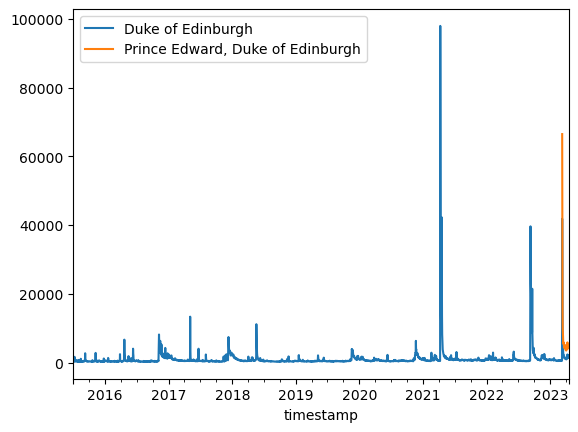

In [148]:
pageviews_df[['Platinum Jubilee of Elizabeth II','Prince Edward, Duke of Edinburgh']].plot()

Other qualitative combinations can be interesting.

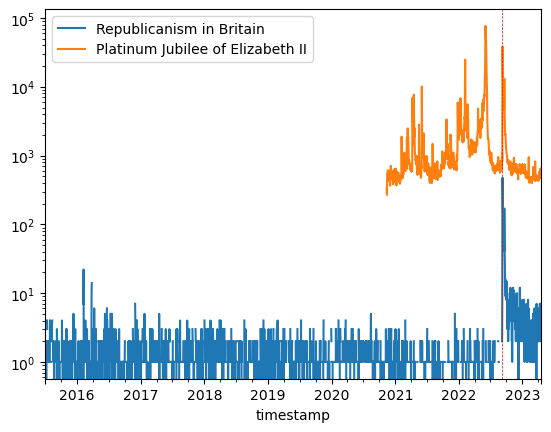

In [151]:
ax = pageviews_df[['Republicanism in Britain','Platinum Jubilee of Elizabeth II']].plot(logy=True)
ax.axvline(pd.Timestamp('2022-09-08'),lw=.5,c='r',ls='--')

## Converting relational data into networks

### Directed network

Elizabeth II has a bit too much activity to make it a good introduction. Let's make a network of all the hyperlinks from "[Whitman College](https://en.wikipedia.org/wiki/Whitman_College)" to its neighbors. This is a "one-step ego network."

In [33]:
new_title = "Whitman College"

# Make an empty dictionary to fill with data
page_outlinks_d = dict()

# Fill it with our primary article
page_outlinks_d[new_title] = wf.get_page_outlinks(new_title)

# Inspect
len(page_outlinks_d[new_title])

247

Now for all these neighboring articles, get their outlinks. This is the "two-step ego network."

In [36]:
for _article in page_outlinks_d[new_title]:
    
    # Try to get the outlinks for the neighbor
    try:
        page_outlinks_d[_article] = wf.get_page_outlinks(_article)
    
    # Break the loop if I interrupt
    except KeyboardInterrupt:
        break
    
    # If there's an error print the article name and keep going
    except:
        print("Error on: {0}".format(_article))
        pass

We spent so much time getting this data, we should save it someplace safer than memory.

In [37]:
with open('article_outlinks.json','w') as f:
    json.dump(page_outlinks_d,f)

The `page_outlinks_d` dictionary is basically a "adjacency list": for a key, each element in the list of the corresponding value is a neighbor. We can turn this into a `networkx` DiGraph object that respects the direction of these ties.

In [38]:
# Start with an empty DiGraph object
hyperlink_graph = nx.DiGraph()

# For each article and its hyperlink neighbors
for _article,_article_list in page_outlinks_d.items():
    
    # For each neighbor in the hyperlink neighbor
    for _neighbor in _article_list:
        
        # Add a tie from the article to the neighbor
        hyperlink_graph.add_edge(_article,_neighbor)

Print out some basic statistics about the network.

In [39]:
print(hyperlink_graph.number_of_nodes())
print(hyperlink_graph.number_of_edges())

23573
30938


Maybe we only care about the links among the neighbors of the first step but not all the neighbors-of-neighbors. This is the "one-and-a-half step ego network" encompassing the links from Whitman College to its neighbors and the links among the neighbors.

In [40]:
hyperlink_subgraph = nx.subgraph(G = hyperlink_graph,nbunch=page_outlinks_d[new_title])

print(hyperlink_subgraph.number_of_nodes())
print(hyperlink_subgraph.number_of_edges())

221
584


A classic and easy network metric is density: how many edges connecting nodes exist divided by how many edges could exist. In a directed network with no self-loops (nodes connecting to themselves), the maximum number of edges with $N$ nodes is $N(N-1)$ if every node connected to every other node except itself. So the density $d$ of a directed network with $M$ edges is: 

\begin{equation}
d_{directed} = \frac{M}{N(N-1)}
\end{equation}

Most real world networks are sparse, meaning their densities are low: typically below 0.1, or only 10% of the possible edges are present.

In [105]:
# The full hyperlink network, somewhat misleading since neighbors neighbors aren't allowed to connect
nx.density(hyperlink_graph)

5.567765639487992e-05

In [103]:
# The subgraph of the only the neighbors who were allowed to connect
nx.density(hyperlink_subgraph)

0.012011517893870834

Write out the graph file to GEXF format to visualize in Gephi.

In [130]:
nx.write_gexf(hyperlink_graph,'hyperlink_graph.gexf')

In [131]:
nx.write_gexf(hyperlink_subgraph,'hyperlink_subgraph.gexf')

### Bipartite network

Let's explore how the editors to Whitman College overlap with the editors to Wikipedia articles listed on "[Consortium of Liberal Arts Colleges](https://en.wikipedia.org/wiki/Consortium_of_Liberal_Arts_Colleges)".

In [43]:
clac_colleges = wf.get_page_outlinks("Consortium of Liberal Arts Colleges")
clac_colleges

['Nonprofit',
 'Liberal arts colleges',
 'Oberlin College',
 'S. Frederick Starr',
 'Albion College',
 'Allegheny College',
 'Alma College',
 'Amherst College',
 'Barnard College',
 'Bates College',
 'Beloit College',
 'Bowdoin College',
 'Bryn Mawr College',
 'Bucknell University',
 'Carleton College',
 'Claremont McKenna College',
 'Colby College',
 'Colgate University',
 "College of Saint Benedict and Saint John's University",
 'College of the Holy Cross',
 'College of Wooster',
 'Colorado College',
 'Connecticut College',
 'Davidson College',
 'Denison University',
 'DePauw University',
 'Dickinson College',
 'Earlham College',
 'Franklin and Marshall College',
 'Gettysburg College',
 'Grinnell College',
 'Hamilton College (New York)',
 'Hampshire College',
 'Harvey Mudd College',
 'Haverford College',
 'Hobart and William Smith Colleges',
 'Hope College',
 'Kalamazoo College',
 'Kenyon College',
 'Lafayette College',
 'Lake Forest College',
 'Lawrence University',
 'Luther College

Skipping down to Albion College, get the revision histories for each of these articles.

In [46]:
# Make an empty container to fill with data
clac_revision_history_d = {}

# For each article starting at index 4 onwards
for _article in clac_colleges[4:]:
    
    # Try to get the revision history for the article
    try:
        clac_revision_history_d[_article] = wf.get_all_page_revisions(_article)
        
    # Break the loop if I force it to stop
    except KeyboardInterrupt:
        break
    
    # If there's an error, print the article name and move on
    except:
        print("Error on {0}".format(_article))
        pass

Concatenate all the article DataFrames together into a giant DataFrame.

In [47]:
# Concatenate college-level DataFrames together
clac_df = pd.concat(clac_revision_history_d)

# Idiosyncrasy involving timestamps, just cast to consistent type
clac_df['timestamp'] = pd.to_datetime(clac_df['timestamp'])

# Inspect
clac_df.head()

revid  parentid     user userid                 timestamp  \
Albion College 0  2555528         0  Bkonrad  44062 2004-02-15 19:30:44+00:00   
               1  2738887   2555528  Bkonrad  44062 2004-02-28 02:33:59+00:00   
               2  2739502   2738887  Bkonrad  44062 2004-03-12 21:34:40+00:00   
               3  2739596   2739502  Bkonrad  44062 2004-03-12 22:17:31+00:00   
               4  2742226   2739596  Bkonrad  44062 2004-03-12 22:36:17+00:00   

                  size                                      sha1  \
Albion College 0   736  ee80a48c69a2597a24368ff0205bac063a41a745   
               1   740  4f53697708cf43c4112e39af179031c84e565b42   
               2  2795  5b03c14fd13a17e139ce61bd32a49ed62590b41d   
               3  2791  41cc9d6ff75d075951a63828d257890c6d08a43d   
               4  2791  0e3e5d484ce01cbd82a0a649f77742ad7b667dea   

                                comment anon sha1hidden            page  \
Albion College 0                         NaN        NaN  Albion College   
               1                         NaN        NaN  Albion College   
               2         +early history  NaN        NaN  Albion College   
               3  revise date, see talk  NaN        NaN  Albion College   
               4           modify dates  NaN        NaN  Albion College   

                        date    diff        lag        age commenthidden  \
Albion College 0  2004-02-15     NaN        NaN   0.000000           NaN   
               1  2004-02-28     4.0  1062195.0  12.293924           NaN   
               2  2004-03-12  2055.0  1191641.0  26.086065           NaN   
               3  2004-03-12    -4.0     2571.0  26.115822           NaN   
               4  2004-03-12     0.0     1126.0  26.128854           NaN   

                 suppressed userhidden  
Albion College 0        NaN        NaN  
               1        NaN        NaN  
               2        NaN        NaN  
               3        NaN        NaN  
               4        NaN        NaN

We spent so much time getting this data, we should save it someplace safer than memory.

In [48]:
clac_df.to_csv('revision_histories_clac.csv',index=False)

Count up the number of times an editor contributed to an article.

In [52]:
# Perform a groupby-aggregation on the user-page level and aggregate by the number of unique revision IDs
user_page_counts = clac_df.groupby(['user','page']).agg({'revid':'nunique'})

# Inspect by sorting the revisions in ascending order
user_page_counts['revid'].sort_values(ascending=False).head(10)

user           page                    
Sdkb           Pomona College              1278
Classicfilms   Mount Holyoke College        801
Broadmoor      Spelman College              635
               Morehouse College            577
LaSaltarella   Ohio Wesleyan University     438
69.121.23.234  Wesleyan University          300
Brit2010       Middlebury College           246
74.88.196.81   Wesleyan University          234
67.80.123.164  Wesleyan University          232
69.121.22.66   Amherst College              232
Name: revid, dtype: int64

Reset this MultiIndex series back to a simpler DataFrame that is an "edgelist" and rename the "revid" column to "weight".

In [55]:
user_page_counts_el = user_page_counts.reset_index()

user_page_counts_el = user_page_counts_el.rename(columns={'revid':'weight'})

user_page_counts_el.head()

,user,page,weight
0,(aeropagitica),Claremont McKenna College,1
1,-5-,College of the Holy Cross,1
2,-Alabama-,Denison University,1
3,-Bobby,Hamilton College,5
4,.anacondabot,Wesleyan University,1


Use the `networkx` function [`from_pandas_edgelist`](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html) to convert this edgelist into a Graph object.

In [57]:
clac_g = nx.from_pandas_edgelist(
    df = user_page_counts_el,
    source = 'user',
    target = 'page',
    edge_attr = ['weight'],
    create_using = nx.Graph
)

print(clac_g.number_of_nodes())
print(clac_g.number_of_edges())

39321
53180


That's a lot of edits. Maybe let's just filter to revisions since 2022.

In [91]:
# Filter to dates since January 1, 2022
clac_recent_df = clac_df[clac_df['timestamp'] >= '2022-01-01']

# Perform groupby-aggregation to count recent users
recent_user_counts = clac_recent_df.groupby(['user','page']).agg({'revid':'nunique'})

# Reset to simpler flat format
recent_user_counts_el = recent_user_counts.reset_index()

# Rename column
recent_user_counts_el = recent_user_counts_el.rename(columns={'revid':'weight'})

# Inspect
recent_user_counts_el.head()

,user,page,weight
0,-Alabama-,Denison University,1
1,0mtwb9gd5wx,Vassar College,1
2,100.0.105.232,Lafayette College,1
3,100.15.202.166,Wellesley College,1
4,100.16.220.184,Rhodes College,1


In [92]:
clac_recent_g = nx.from_pandas_edgelist(
    df = recent_user_counts_el,
    source = 'user',
    target = 'page',
    edge_attr = ['weight'],
    create_using = nx.Graph
)

print(clac_recent_g.number_of_nodes())
print(clac_recent_g.number_of_edges())

1503
2319


There are two types of nodes in this network: users and pages. We enforce a constraint that edges can only exist from users to pages; user-user and page-page relationships are not permitted because users cannot edit users and pages cannot edit pages. 

Check this bipartite assumption with `networkx`'s "[bipartite](https://networkx.org/documentation/stable/reference/algorithms/bipartite.html)" sub-module.

In [93]:
clac_revision_users = recent_user_counts_el['user'].unique()
clac_revision_pages = recent_user_counts_el['page'].unique()

print("There are {0:,} unique users.".format(len(clac_revision_users)))
print("There are {0:,} unique pages.".format(len(clac_revision_pages)))

There are 1,429 unique users.
There are 74 unique pages.


Sometimes a username and a page name are identical, which upsets this assumption. Let's check!

In [94]:
set(clac_revision_users) & set(clac_revision_pages)

set()

The `.is_bipartite` method will check this bipartite constraint.

In [95]:
nx.bipartite.is_bipartite(clac_g)

True

Bipartite networks have a special density calculation because we only permit links to exist *between* node sets (editors revise articles) and not *within* node sets (editors revise editors or articles revise articles).

The density $d$ of an undirected bipartite network $B$ with $M$ observed edges and a node set A of size $N_{a}$ and a complementary node set B of size $N_{b}$ is:
\begin{equation}
d_{bipartite} = \frac{M}{N_a N_b}
\end{equation}

In [107]:
nx.bipartite.density(clac_recent_g,clac_revision_users)

0.021929907514232218

If we use the non-bipartite definition of density where all nodes are allowed to connect with each other, we get an erroneously low density (off by a factor of 10!) because it is counting possible connections that we do not permit to exist.

In [108]:
nx.density(clac_recent_g)

0.0020544795894230183

Write out the network to GEXF to visualize in Gephi.

In [132]:
nx.write_gexf(clac_recent_g,'collaboration_graph.gexf')

### Undirected network

An *undirected* network is a graph where the relationships are all symmetric or a directional is not meaningful. A classic example is a Facebook friend relation: it exists or it doesn't but there is no meaningful direction from *from* X and *to* Y.

We can convert the bipartite networks of editor-article interactions into two kinds of "projected" networks that are undirected.

* **article projection** Two articles are connected to each other if they share an editor in common
* **editor projection** Two editors are connected to each other if they edited an article in common
* **pageview correlation** Two articles are connected to each other if they are strongly corrleated

#### Projection networks
Only the users are present in the network, but we have created ties between the users based on whether (and how many!) articles they contributed to together.

In [98]:
clac_user_proj_g = nx.bipartite.weighted_projected_graph(clac_recent_g,clac_revision_users)

print("There are {0:,} nodes in the user projected network.".format(clac_user_proj_g.number_of_nodes()))
print("There are {0:,} edges in the user projected network.".format(clac_user_proj_g.number_of_edges()))

There are 1,429 nodes in the user projected network.
There are 36,333 edges in the user projected network.


Only the articles are present in this projected network, but we have created ties between the articles based on whether and how many editors contributed to them together.

In [99]:
clac_page_proj_g = nx.bipartite.weighted_projected_graph(clac_recent_g,clac_revision_pages)

print("There are {0:,} nodes in the user projected network.".format(clac_page_proj_g.number_of_nodes()))
print("There are {0:,} edges in the user projected network.".format(clac_page_proj_g.number_of_edges()))

There are 74 nodes in the user projected network.
There are 2,701 edges in the user projected network.


The density of an undirected network has half as many possible edges as a directed network: a connection from A to B is the same as B to A. This is not the case in a directed network. We add a scaling factor of one-half (two) to the undirected network density defintion to define an undirected network density $d$ with $M$ observed edges and $N$ nodes.

\begin{equation}
d_{undirected} = \frac{M}{\frac{N(N-1)}{2}} = \frac{2 M}{N(N-1)}
\end{equation}

These projected networks tend to be very dense relative to other networks. A single article/editor in common among many editors/articles will make all these editors/articles connected to each other.

In [109]:
nx.density(clac_user_proj_g)

0.035609905263715005

In [110]:
nx.density(clac_page_proj_g)

1.0

Write out the user network to visualize in Gephi.

In [133]:
nx.write_gexf(clac_user_proj_g,'collaboration_graph.gexf')

#### Correlation networks

Filter `pv_corr` to only include correlations greater than 0.5.

In [156]:
pv_corr_gt = pv_corr[pv_corr > .8]

pv_corr_gt

,Elizabeth II,Breach of confidence in English law,"Sarah, Duchess of York",Union of South Africa,Treaty of Rome,Greek Orthodoxy,47th G7 summit,Operation Unicorn (Scotland),Marcus Sarjeant,Colonel,...,Income tax,Paul Martin Sr.,Harry S. Truman,Children's Hour,Jean Chrétien,Apartheid,Tony Benn,Wedding of Princess Elizabeth and Philip Mountbatten,St Giles' Cathedral,John Paul II
Elizabeth II,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.986548,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Breach of confidence in English law,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Sarah, Duchess of York",NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Union of South Africa,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Treaty of Rome,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Apartheid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Tony Benn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Wedding of Princess Elizabeth and Philip Mountbatten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
St Giles' Cathedral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


Convert to an edgelist.

In [164]:
corr_el = pv_corr_gt.where(np.triu(np.ones(pv_corr_gt.shape),1).astype(bool)).stack()
corr_el = corr_el.reset_index()
corr_el.columns = ['Source','Target','Weight']
corr_el.sort_values('Weight',ascending=False).head(10)

,Source,Target,Weight
2752,Duke of Edinburgh,"Prince Edward, Duke of Edinburgh",0.999506
829,"Death and funeral of Prince Philip, Duke of Ed...",Death and funeral of Mary of Teck,0.997842
1636,Death and funeral of Alexandra of Denmark,Death and funeral of Mary of Teck,0.997609
1530,United Kingdom's accession to the European Com...,Platinum Jubilee of Elizabeth II,0.997490
1462,United Kingdom's accession to the European Com...,Republicanism in Britain,0.996920
1458,United Kingdom's accession to the European Com...,Philip Mountbatten,0.996188
1493,United Kingdom's accession to the European Com...,Coronation Oath,0.995963
1115,Head of the Commonwealth,United Kingdom's accession to the European Com...,0.995816
139,Operation Unicorn (Scotland),Queen of the United Kingdom,0.994412
1424,United Kingdom's accession to the European Com...,Prince of Greece and Denmark,0.994143


Turn the edgelist into a network `pv_corr_g`.

In [165]:
pv_corr_g = nx.from_pandas_edgelist(
    df = corr_el,
    source = 'Source',
    target = 'Target',
    edge_attr = ['Weight']
)

print("There are {0:,} nodes in the article correlation network.".format(pv_corr_g.number_of_nodes()))
print("There are {0:,} edges in the article correlation network.".format(pv_corr_g.number_of_edges()))

There are 325 nodes in the article correlation network.
There are 4,097 edges in the article correlation network.


What's the density of the correlation network?

In [166]:
nx.density(pv_corr_g)

0.07781576448243115

Write `pv_corr_g` to a GEXF file to visualize in Gephi.

In [174]:
nx.write_gexf(pv_corr_g,'pageview_correlation.gexf')